# ADA Project: 2018's Best Hit

In [359]:
import numpy as np
import pandas as pd

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time

import h5py
import hdf5_getters
from hdf5_getters import *

from operator import methodcaller

In [307]:
def count_all_files(base_directory, ext='.h5') :
    cnt = 0
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
    return cnt

In [308]:
def get_all(getter, base_directory, ext='.h5'):
    values = []
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            h5 = hdf5_getters.open_h5_file_read(f)
            values.append( getter(h5) )
            h5.close()
    return values

In [309]:
def get_file_fields(file, all_getters):
    fields = []
    for getter_name in all_getters:
        getter = getattr(hdf5_getters, getter_name)
        fields.append(getter(h5))
    return fields

In [310]:
base_directory = './millionsongsubset_full/MillionSongSubset/data'

In [311]:
print('Number of songs:', count_all_files(base_directory))

Number of songs: 10000


In [312]:
all_getters = list(filter(lambda x: x[:3] == 'get',hdf5_getters.__dict__.keys()))
print(all_getters)
print('Number of getters:', len(all_getters))

['get_num_songs', 'get_artist_familiarity', 'get_artist_hotttnesss', 'get_artist_id', 'get_artist_mbid', 'get_artist_playmeid', 'get_artist_7digitalid', 'get_artist_latitude', 'get_artist_longitude', 'get_artist_location', 'get_artist_name', 'get_release', 'get_release_7digitalid', 'get_song_id', 'get_song_hotttnesss', 'get_title', 'get_track_7digitalid', 'get_similar_artists', 'get_artist_terms', 'get_artist_terms_freq', 'get_artist_terms_weight', 'get_analysis_sample_rate', 'get_audio_md5', 'get_danceability', 'get_duration', 'get_end_of_fade_in', 'get_energy', 'get_key', 'get_key_confidence', 'get_loudness', 'get_mode', 'get_mode_confidence', 'get_start_of_fade_out', 'get_tempo', 'get_time_signature', 'get_time_signature_confidence', 'get_track_id', 'get_segments_start', 'get_segments_confidence', 'get_segments_pitches', 'get_segments_timbre', 'get_segments_loudness_max', 'get_segments_loudness_max_time', 'get_segments_loudness_start', 'get_sections_start', 'get_sections_confidence'

#### Building the dataframe (only subset)

*note: skip this section if the dataframe has  already been saved to .csv*

In [ ]:
#iterate over all the .h5 files, starting from the base directory
#note: takes between ~8 to ~10 minutes
start_time = time.time()

values = []
ext = '.h5'

for root, dirs, files in os.walk(base_directory):
    files = glob.glob(os.path.join(root, '*'+ext))
    for f in files:
        h5 = hdf5_getters.open_h5_file_read(f)
        values.append(get_file_fields(h5, all_getters))
        h5.close()        

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

In [ ]:
#create the column names from the getter names
column_names = []
for getter_name in all_getters:
    column_names.append(getter_name[4:].replace('_', ' '))

In [ ]:
#create a dataframe with the given column names
data = pd.DataFrame(columns=column_names)
data.head()

In [ ]:
#fill the dataframe row by row
nb_entries = len(values)
for i in range(0, nb_entries):
    data.loc[i] = values[i]

In [ ]:
data.head()

In [ ]:
#write the dataframe to a .csv file
#note: takes several minutes
start_time = time.time()
data.to_csv('msd_data.csv', sep='\t', encoding='utf-8')
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

#### Retrieving the dataframe

In [417]:
data = pd.read_csv('msd_data_save.csv', sep='\t', index_col=0)
data.head()

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year
0,1,0.581794,0.401998,b'ARD7TVE1187B99BFB1',b'e77e51a5-4761-45b3-9847-2051f811e366',4479,165270,NaN,NaN,b'California - LA',...,[ 1. 1. 0.218 0.133 0.384 0.326 0....,[ 0.58521 1.19196 1.78893 2.37813 ...,[ 0.834 0.851 0.65 0.635 0.532 0.753 0....,[ 0.58521 2.94247 5.14371 7.74554 ...,[ 0.643 0.746 0.722 0.095 0.091 0.362 0....,[ 0.28519 0.58521 0.89422 1.19196 ...,[ 0.779 0.734 0.674 0.637 0.597 0.532 0....,[],[],0
1,1,0.630630,0.417500,b'ARMJAGH1187FB546F3',b'1c78ab62-db33-4433-8d0b-7c8dcf1849c2',22066,1998,35.14968,-90.04892,"b'Memphis, TN'",...,[ 1. 0.451 0.27 0.397 0.225 0.426 0....,[ 0.20627 0.71054 1.21836 1.71841 ...,[ 1. 0.945 0.714 0.973 0.818 0.974 0....,[ 0.71054 2.71502 4.70861 6.69288 ...,[ 0.007 0.259 0.172 0.404 0.011 0.016 0....,[ 0.20627 0.45904 0.71054 0.96834 ...,[ 0.969 0.929 0.897 0.871 0.856 0.845 0....,[b'classic pop and rock'],[1],1969
2,1,0.487357,0.343428,b'ARKRRTF1187B9984DA',b'7a273984-edd9-4451-9c4d-39b38f05ebcd',13951,290021,NaN,NaN,b'',...,[ 1. 0.121 0.214 0.198 0.66 0.468 0....,[ 0.73152 1.39732 2.04852 2.68691 ...,[ 0.98 0.399 0.185 0.27 0.422 0. 0....,[ 0.73152 1.39732 2.04852 2.68691 ...,[ 0.98 0.399 0.185 0.27 0.422 0. 0....,[ 0.42132 0.73152 1.06609 1.39732 ...,[ 0.482 0.676 0.627 0.549 0.279 0.264 0....,[],[],0
3,1,0.630382,0.454231,b'AR7G5I41187FB4CE6C',b'e188a520-9cb7-4f73-a3d7-2f70c6538e92',12697,19072,NaN,NaN,"b'London, England'",...,[ 1. 0.086 0.153 0.146 0.088 0.217 0....,[ 0.81002 1.30621 1.80617 2.2996 ...,[ 0.809 0.616 0.789 0.66 0.439 0.758 0....,[ 1.30621 3.29887 5.30252 7.32327 ...,[ 0.017 0.05 0.014 0.008 0.114 0.019 0....,[ 0.56254 0.81002 1.05749 1.30621 ...,[ 0.601 0.556 0.523 0.49 0.466 0.44 0....,[b'uk' b'british' b'english'],[1 1 1],1982
4,1,0.651046,0.401724,b'ARXR32B1187FB57099',b'c6903a2e-063c-4f91-a284-17b8f421be7b',8355,30973,NaN,NaN,b'',...,[ 1. 0.768 0.611 0.388 0.52 0.42 0....,[ 1.35760000e-01 5.99140000e-01 1.0636800...,[ 0.883 0.738 0.484 0.609 0.625 0.719 0....,[ 1.06368 2.91491 4.76729 6.61852 ...,[ 0.175 0.409 0.639 0.067 0.016 0.066 0....,[ 1.35760000e-01 3.69180000e-01 5.9914000...,[ 1. 0.98 0.932 0.87 0.82 0.793 0....,[],[],2007


#### Basic statistics

- ranges, mean, median, ...
- graphs

We give a basic overview of the (most important) features of the songs, using pandas `describe()` method.

In [110]:
def describe(data, column, include_undefined):
    if(include_undefined):
        return pd.DataFrame(data[column]).describe()
    else:
        return pd.DataFrame(data[data[column] != 0][column]).describe()
                        

In [135]:
def set_ticks_wtih_step(ax, step):
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::step])
    ax.xaxis.set_ticklabels(ticklabels[::step]);

#### Release year

In [108]:
describe(data, 'year', True)

,year
count,10000.000000
mean,934.704600
std,996.650657
min,0.000000
25%,0.000000
50%,0.000000
75%,2000.000000
max,2010.000000


We see that the minimum `year` is 0, which actually stands for `undefined`. In our statistics, we will from now on not include those songs for which a certain feature is undefined, as this would bias the distributions.

In [111]:
describe(data, 'year', False)

,year
count,4680.000000
mean,1997.232051
std,11.686691
min,1926.000000
25%,1993.000000
50%,2001.000000
75%,2006.000000
max,2010.000000


Now the earliest `year` is 1926, which indeed appears to  be more realistic. The majority of the songs in the dataset has been released in the last 20 years, although the most recent ones date back to 2010 already. 

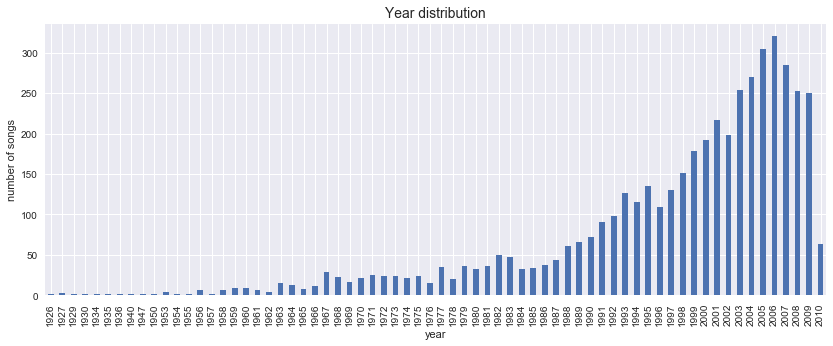

In [124]:
ax = data[data['year'] > 0]['year'].value_counts()\
                                   .sort_index()\
                                   .plot(kind='bar',
                                         grid=True,
                                         figsize=(14, 5));
        
ax.set_title('Year distribution', fontsize=14)
ax.set_xlabel('year')
ax.set_ylabel('number of songs');

Most of the songs we are going to deal with came out in 2000 and later. Hopefully, the ones which were popular in 2011, when the Million Song Dataset was created, remain so to these days. Otherwise, predicting the 2018's best hit might prove more challenging than expected!

#### Song hotttnesss

In [125]:
describe(data, 'song hotttnesss', False)

,song hotttnesss
count,4214.000000
mean,0.459482
std,0.168239
min,0.187895
25%,0.313562
50%,0.450762
75%,0.586366
max,1.000000


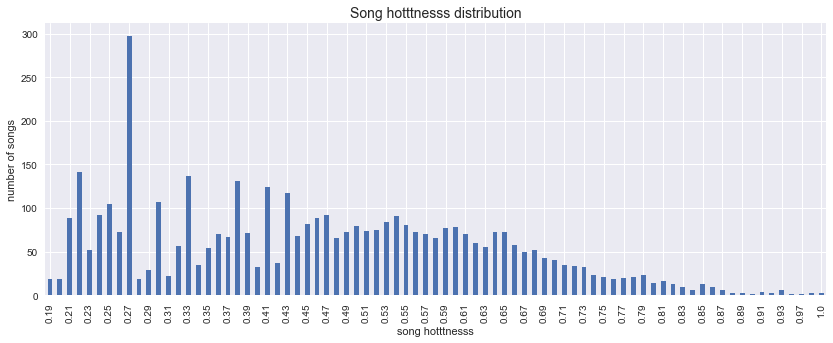

In [150]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of buckets
ax = round(data[data['song hotttnesss'] > 0]['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_wtih_step(ax, 2)

*Unknown ditribution...*

#### Artist hotttnesss

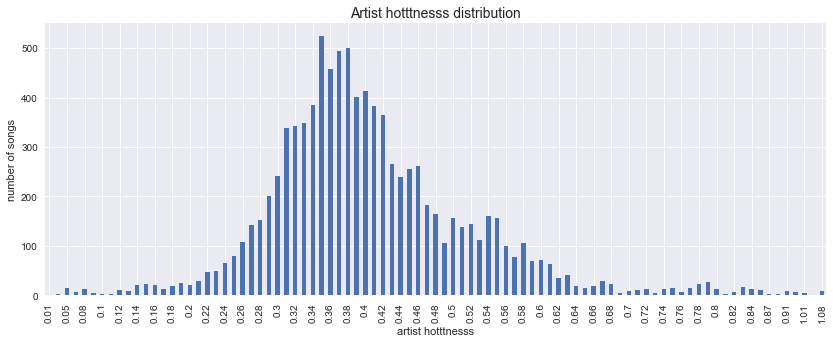

In [143]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of buckets
ax = round(data[data['artist hotttnesss'] > 0]['artist hotttnesss'], 2).value_counts()\
                                                                       .sort_index()\
                                                                       .plot(kind='bar',
                                                                             grid=True,
                                                                             figsize=(14, 5));
ax.set_title('Artist hotttnesss distribution', fontsize=14)
ax.set_xlabel('artist hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_wtih_step(ax, 2)

*Oh....! Gaussian-like distribution...! ... or is it lognormal...?*

#### Song duration

In [33]:
data['duration'].head()

0    218.93179
1    148.03546
2    177.47546
3    233.40363
4    209.60608
Name: duration, dtype: float64

In [67]:
int(data['duration'].max())

1819

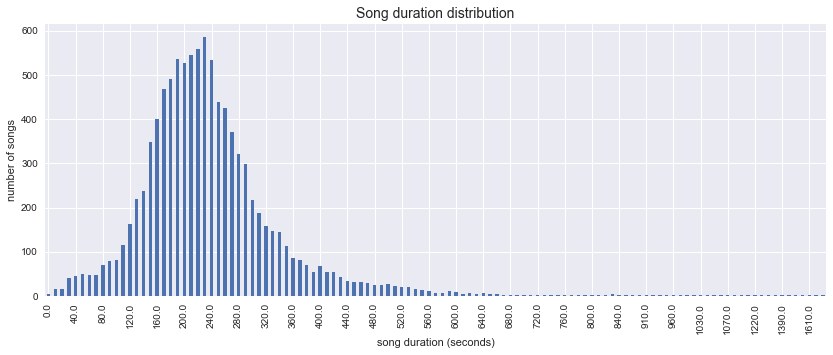

In [146]:
ax = round(data['duration'], -1).value_counts()\
                                .sort_index()\
                                .plot(kind='bar', 
                                      grid=True,
                                      figsize=(14, 5));
        
ax.set_title('Song duration distribution', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('number of songs')
set_ticks_wtih_step(ax, 4)

*Lognormal? Gamma? Weibull?*

Probably a lognormal distribution, as many natural phenomenons related to some *length* - like a song duration - have been observed to follow a lognormal ditribution.

#### Non-evaluated features

Unfortunately, some features such as `energy` or `danceability` happen to not have been evaluated for any of the songs in the dataset. This means we will not be able to use them in our analysis.

In [153]:
describe(data, 'energy', True)

,energy
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [259]:
describe(data, 'danceability', True)

,danceability
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


#### Artist terms

In [420]:
old_artist_terms = data['artist terms'].copy()

In [431]:
data['artist terms'] = old_artist_terms

In [432]:
#prevents running the tranformation of 'artist terms' from string to list twice
if(type(data['artist terms'].head(1)[0]) == str):
    #clean the string
    a = data['artist terms'].apply(lambda x: x.replace('b\'', '')
                                              .replace('b"', '')
                                              .replace('"', '\'')
                                              .replace('[', '')
                                              .replace(']', '')
                                              .replace('\n', ''))

    #split every term at every <' > position (single quote followed by a space)
    artist_terms = map(methodcaller('split', '\' '), a)
    #remove every quote
    artist_terms = map(lambda x: [s.replace('\'', '') for s in x], artist_terms)
    #transform the map into a list
    artist_terms = list(artist_terms)
    
    data['artist terms'] = artist_terms

In [433]:
top_list = data['artist terms']
artist_terms_all = [item for sublist in top_list for item in sublist]
artist_terms_distinct = set(artist_terms_all)

print('Total number of artist terms:', len(artist_terms_all))
print('Number of distinct artist terms:', len(artist_terms_distinct))

Total number of artist terms: 263967
Number of distinct artist terms: 3896


In [463]:
serie = pd.Series(artist_terms_all).value_counts()

In [452]:
serie.sort_values(ascending=False).head(10)

rock                6435
pop                 5439
electronic          4378
jazz                3563
united states       3056
hip hop             2849
alternative rock    2733
folk                2591
alternative         2582
soul                2450
dtype: int64

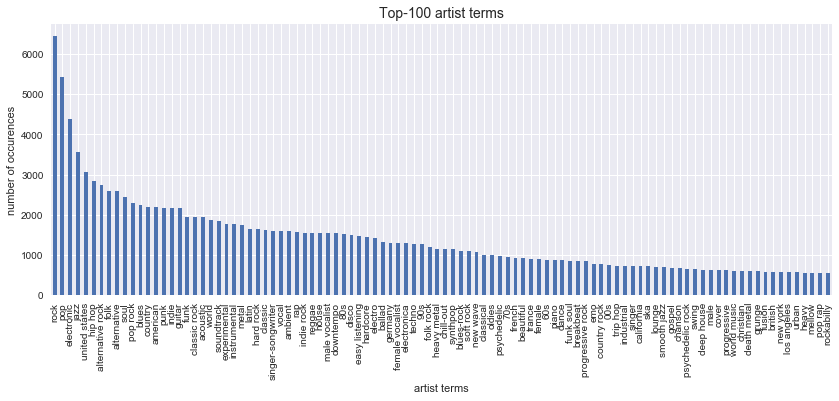

In [458]:
ax = serie.sort_values(ascending=False).head(100)\
                                       .plot(kind='bar',
                                             grid=True,
                                             figsize=(14, 5));
    
ax.set_title('Top-100 artist terms', fontsize=14)
ax.set_xlabel('artist terms')
ax.set_ylabel('number of occurences');

It would seem the songs in this dataset are heavily rock and pop oriented. (and western oriented too)

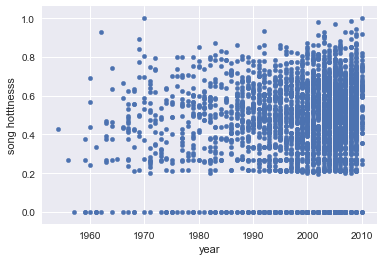

In [410]:
data[data['year'] != 0].plot(kind='scatter', x='year', y='song hotttnesss')

In [69]:
data[data['song hotttnesss'] > 0.9]['artist terms'].sort_values(ascending=False)

1160    [b'teen pop' b'pop punk' b'pop rock' b'punk' b...
2431    [b'southern rock' b'alternative rock' b'rock' ...
1427    [b'rock' b'singer-songwriter' b'folk' b'soundt...
2109    [b'reggae' b'hip hop' b'pop' b'jamaica' b'danc...
2351    [b'rap rock' b'funk metal' b'funk rock' b'heav...
5699    [b'pop' b'rock' b'alternative' b'modern rock' ...
1208    [b'pop rock' b'all-female' b'ballad' b'europop...
1594    [b'pop punk' b'punk' b'pop' b'punk pop' b'emo ...
5355    [b'neo soul' b'blues' b'soul' b'pop' b'urban' ...
6482    [b'jazz rap' b'hip hop' b'neo soul' b'chill-ou...
539     [b'jazz funk' b'soul jazz' b'bossa nova' b'fun...
3277    [b'indie rock' b'rock' b'pop' b'alternative' b...
3544    [b'experimental rock' b'post rock' b'progressi...
7917    [b'experimental rock' b'post rock' b'progressi...
6437    [b'dirty south rap' b'hard rock' b'hip hop' b'...
9137    [b'blues-rock' b'heavy metal' b'hard rock' b'c...
9724    [b'blues-rock' b'garage rock' b'blues' b'alter...
1354    [b'art

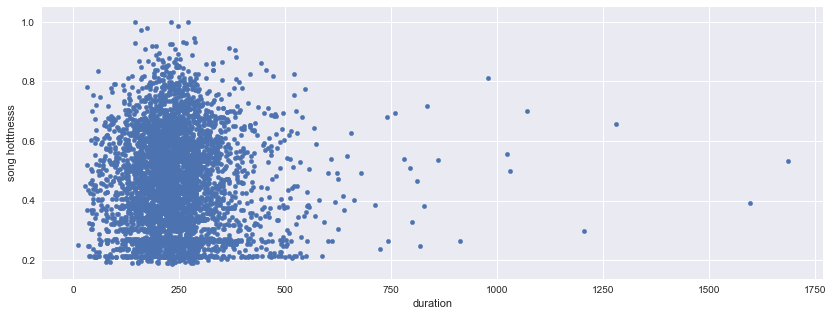

In [53]:
data[data['song hotttnesss'] != 0].plot(kind='scatter', x='duration', y='song hotttnesss', figsize=(14,5));

In [147]:
#data['artist terms']

In [20]:
all_getters

['get_num_songs',
 'get_artist_familiarity',
 'get_artist_hotttnesss',
 'get_artist_id',
 'get_artist_mbid',
 'get_artist_playmeid',
 'get_artist_7digitalid',
 'get_artist_latitude',
 'get_artist_longitude',
 'get_artist_location',
 'get_artist_name',
 'get_release',
 'get_release_7digitalid',
 'get_song_id',
 'get_song_hotttnesss',
 'get_title',
 'get_track_7digitalid',
 'get_similar_artists',
 'get_artist_terms',
 'get_artist_terms_freq',
 'get_artist_terms_weight',
 'get_analysis_sample_rate',
 'get_audio_md5',
 'get_danceability',
 'get_duration',
 'get_end_of_fade_in',
 'get_energy',
 'get_key',
 'get_key_confidence',
 'get_loudness',
 'get_mode',
 'get_mode_confidence',
 'get_start_of_fade_out',
 'get_tempo',
 'get_time_signature',
 'get_time_signature_confidence',
 'get_track_id',
 'get_segments_start',
 'get_segments_confidence',
 'get_segments_pitches',
 'get_segments_timbre',
 'get_segments_loudness_max',
 'get_segments_loudness_max_time',
 'get_segments_loudness_start',
 'ge